In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.distributions import Normal
from torch.distributions import StudentT
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import math
from scipy.stats import norm
from collections import defaultdict
from random import uniform
from tqdm import tqdm
import scipy.stats
from scipy.integrate import quad
from torch.optim.optimizer import Optimizer, required

In [2]:
class ArbitraryMomentumSGD(Optimizer):
    def __init__(self, params, lr=required, momentum_schedule=None):
        """
        Custom SGD that accepts arbitrary momentum (can be negative or >1).
        
        Arguments:
        - params: model parameters
        - lr: learning rate
        - momentum_schedule: callable or float.
            If callable: should return momentum given current step.
            If float: fixed momentum value.
        """
        defaults = dict(lr=lr, momentum_schedule=momentum_schedule, step=0)
        super(ArbitraryMomentumSGD, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step."""

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            step = group['step']
            momentum_schedule = group['momentum_schedule']

            # Evaluate momentum
            if callable(momentum_schedule):
                momentum = momentum_schedule(step)
            else:
                momentum = momentum_schedule

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                # Initialize velocity if not present
                state = self.state[p]
                if 'velocity' not in state:
                    state['velocity'] = torch.zeros_like(p.data)

                v = state['velocity']
                v.mul_(momentum).add_(d_p, alpha=-lr)
                p.data.add_(v)

            # Increment step counter
            group['step'] += 1

        return loss

In [3]:
class SuperModel(nn.Module):
    def __init__(self, asset_size, h_size, volume_h_size, metrics_h_size, n_layers, batch_size, seq_len,
                 pre_heads, time_heads, asset_heads, num_studentT,
                 value_size, dropout=0.0):
        super().__init__()

        self.asset_out_size = asset_size
        self.value_size = value_size
        self.h_size = h_size
        self.seq_len = seq_len
        self.num_studentT = num_studentT

        self.base_model = MultiTimescaleLSTM(asset_size, h_size, n_layers, batch_size, seq_len,
                                             pre_heads, time_heads, asset_heads, num_studentT,
                                             value_size, dropout)
        
        self.volume_head = VolumeMetaHead(volume_h_size, num_studentT, dropout)
        
        self.financial_performance_head = FinancialPerformanceHead(batch_size, asset_size, num_studentT, 
                                                                   metrics_h_size, dropout)

    def disable_dropout(self):
        # Recursively replace all nn.Dropout with nn.Identity
        for name, module in self.named_modules():
            if isinstance(module, nn.Dropout):
                module.p = 0.0  # optional if you want to preserve layer
                module.__class__ = nn.Identity

    def forward(self, x, performance_metrics):
        """ x: [B, A, V + 1, T] """
        # <== Reshape data ==>
        volume = x[:, :, 5, :]                       # [B, A, T]
        ohlc = x[:, :, :5, :]                        # [B, A, V, T]
        
        ohlc = ohlc.transpose(1, 3)                  # [B, T, V, A] (Transpose for lstm)
        B, T, V, A = ohlc.shape
        
        log_volume = torch.log1p(volume)

        # <== get model predictions ==>
        mu, sigma, nu, dist_weights = self.base_model(ohlc)
        volume_correction = self.volume_head(log_volume)
        performance_correction = self.financial_performance_head(performance_metrics)

        # === Calculate Volume Head Corrections ===            
        mu_vol_corr = volume_correction[:, :, 0, :]    # [B, A, num_studentt]
        sigma_vol_corr = volume_correction[:, :, 1, :]
        nu_vol_corr = volume_correction[:, :, 2, :]
                
        # === Calculate Financial performance Head Corrections ===
        mu_perf_corr = performance_correction[:, :, 0, :]    # [B, A, num_studentt]
        sigma_perf_corr = performance_correction[:, :, 1, :]
        nu_perf_corr = performance_correction[:, :, 2, :]
        
        # === Apply Corrections ===
        corr_scale = 0.5
        mu = mu + ((0 + corr_scale*torch.sigmoid(mu_vol_corr)) + 0*(0 + corr_scale*torch.sigmoid(mu_perf_corr)))
        sigma = sigma + ((0 + corr_scale*torch.sigmoid(sigma_vol_corr)) + 0*(0 + corr_scale*torch.sigmoid(sigma_perf_corr)))
        nu = nu + ((0 + corr_scale*torch.sigmoid(nu_vol_corr)) + 0*(0 + corr_scale*torch.sigmoid(nu_perf_corr)))
        
        return mu, sigma, nu, dist_weights    

In [4]:
class SpatioTemporalCausalAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_assets, num_timesteps):
        super().__init__()
        self.embed = nn.Linear(input_dim, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.output_proj = nn.Linear(embed_dim, embed_dim)
        self.num_assets = num_assets
        self.num_timesteps = num_timesteps

        # Precompute causal time mask
        t = num_timesteps
        a = num_assets
        time_ids = torch.arange(t).repeat(a)  # [A*T]
        mask = time_ids[None, :] <= time_ids[:, None]
        self.register_buffer("causal_mask", (~mask).float() * float('-inf'))  # [A*T, A*T]

    def forward(self, x):
        B, A, T, V = x.shape
        x = x.permute(0, 2, 1, 3).reshape(B, A*T, V)  # [B, A*T, V]
        x = self.embed(x)
    
        # Recreate the mask dynamically in case T is variable
        time_ids = torch.arange(T, device=x.device).repeat(A)
        mask = time_ids[None, :] <= time_ids[:, None]
        causal_mask = (~mask).float() * float('-1e9')  # [A*T, A*T]
    
        attn_out, _ = self.attn(x, x, x, attn_mask=causal_mask)
        x_proj = self.output_proj(attn_out)
        
        return x_proj.reshape(B, T, A, -1).permute(0, 2, 1, 3)  # [B, A, T, E]

In [5]:
class MultiTimescaleLSTM(nn.Module):
    def __init__(self, asset_size, h_size, n_layers, batch_size, seq_len,
                 pre_heads, time_heads, asset_heads, num_studentT,
                 value_size, dropout=0.0):
        super().__init__()

        self.h_size = h_size
        self.num_studentT = num_studentT

        # === Attention Modules ===
        self.spatio_temporal_attn = SpatioTemporalCausalAttention(
            input_dim=value_size,
            embed_dim=h_size,
            num_heads=pre_heads,
            num_assets=asset_size,
            num_timesteps=seq_len
        )

        self.temporal_attn = nn.MultiheadAttention(embed_dim=h_size, num_heads=time_heads, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(embed_dim=h_size, num_heads=asset_heads, batch_first=True)

        # === LSTM ===
        self.lstm = nn.LSTM(
            input_size=asset_size * value_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True
        )

        # === Linear Layers ===
        self.post_fc = nn.Linear(asset_size * h_size, 4 * asset_size * num_studentT)

    def forward(self, ohlc):
        """
        ohlc: [B, T, V, A]
        """
        H = self.h_size
        B, T, V, A = ohlc.shape

        ohlc_flat = ohlc.reshape(B, T, A*V)
        
        #x = x.transpose(2, 3)  # -> [B, A, T, V]

        # === Spatio-Temporal Attention ===
        #x_attn = self.spatio_temporal_attn(x)  # [B, A, T, H]
        #x_attn = x_attn.transpose(1, 2)          # [B, T, A, H]
        #B, T, A, H = x_attn.shape
        #x_flat = x_attn.reshape(B, T, A * H)     # [B, T, A*H]

        # === LSTM ===
        lstm_out, _ = self.lstm(ohlc_flat)          # [B, T, H]

        # === Temporal Attention with Causal Mask ===
        device = lstm_out.device
        causal_mask = torch.triu(torch.full((T, T), float('-inf')), diagonal=1).to(device)
        temp_out, _ = self.temporal_attn(lstm_out, lstm_out, lstm_out, attn_mask=causal_mask)

        # === Cross-Asset Attention ===
        final_state = temp_out[:, -1, :]                  # [B, H]
        expanded = final_state.unsqueeze(1).repeat(1, A, 1)  # [B, A, H]
        asset_out, _ = self.cross_attn(expanded, expanded, expanded)  # [B, A, H]
        asset_flat = asset_out.reshape(B, A * H)          # [B, A*H]

        final = self.post_fc(asset_flat) # [B, A*5]
        final = final.view(B, A, 4, self.num_studentT)

        # === Output Parameters ===
        # [B, A, K]
        mu       = final[:, :, 0, :]
        log_sigma = final[:, :, 1, :]
        log_nu    = final[:, :, 2, :]
        dist_weights = final[:, :, 3, :]

        sigma = torch.exp(log_sigma) + 1e-2
        nu = torch.exp(log_nu) + 2.0
        dist_weights = torch.softmax(dist_weights, dim=-1)

        return mu, sigma, nu, dist_weights

In [6]:
class VolumeMetaHead(nn.Module):
    def __init__(self, hidden_dim, num_studentT, dropout=0.0):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(8, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 16),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(16, 3 * num_studentT),
        )
        self.num_studentT = num_studentT

    def forward(self, log_volume):
        """
        log_vol: [B, A, T]
        Returns:
            correction: [B, A, out_per_asset]
        """
        # Average across time: create a regime signal per asset
        avg_vol = log_volume.mean(dim=-1, keepdim=True)  # [B, A, 1]
        correction = self.fc(avg_vol)                 # [B, A, out_per_asset]

        B, A, _ = correction.shape
        correction = correction.reshape(B, A, 3, self.num_studentT)
        return correction

In [7]:
class FinancialPerformanceHead(nn.Module):
    def __init__(self, B, A, num_studentT, hidden_dim, dropout=0.0):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(6, 16),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(16, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 24),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(24, 3 * num_studentT * A),
        )

        self.B = B
        self.A = A
        self.num_studentT = num_studentT

    def forward(self, performance_metrics):
        correction = self.fc(performance_metrics)
        correction = correction.reshape(self.B, self.A, 3, self.num_studentT)
        return correction

In [8]:
def mixture_student_t_logpdf(x, mus, sigmas, nus, dist_weights):
    """
    Log-likelihood of Mixture of Student-t Distributions.

    Inputs:
        x:        [B, A]         target returns
        mus:      [B, A, K]      mixture component means
        sigmas:   [B, A, K]      std deviations (must be positive)
        nus:      [B, A, K]      degrees of freedom (must be > 2)
        weights:  [B, A, K]      unnormalized weights

    Returns:
        log_prob: [B, A]         log-likelihood of each sample
    """
    x = x.unsqueeze(-1).expand_as(mus)  # [B, A, K]
    t_dist = StudentT(loc=mus, scale=sigmas, df=nus)
    log_pdf = t_dist.log_prob(x)  # [B, A, K]
    log_w = F.log_softmax(dist_weights, dim=-1)  # [B, A, K]
    return torch.logsumexp(log_pdf + log_w, dim=-1)  # [B, A]

In [9]:
def mixture_student_t_loss(mu, sigma, nu, dist_weights, target, deviation=(100., 0.)):

    # Dont punish the network for mispredicting unpredictable targets
    #target = torch.where(((torch.abs(target) < deviation[0]) & (torch.abs(target) > deviation[1])), target, 0.0)

    logp = mixture_student_t_logpdf(target, mu, sigma, nu, dist_weights)
    pdf_loss = -logp.mean()
        
    #sigma_penalty = torch.mean(1.0 / sigma)  # penalize tiny sigma

    # Encourage the network to use all student t distributions
    weight_entropy = -((1 / dist_weights) * dist_weights.log()).sum(dim=-1).mean()

    loss = pdf_loss + weight_entropy * 0.1
    
    return loss.mean()

In [10]:
def performance_metrics_loss(metrics):

    sharpe, drawdown, returns = metrics[:3]
    delta_sharpe, delta_drawdown, delta_returns = metrics[3:]

    absolute_loss = F.sigmoid(sharpe / 1.5 -1) + F.sigmoid(-drawdown*100 / 8.0 -1) + F.sigmoid(returns*100 / 20.0 -1) + 3
    relative_loss = F.gelu(-delta_sharpe / 1.5) + F.gelu(+delta_drawdown*100 / 20) + F.gelu(-delta_returns*100 / 20)
    
    loss = -(absolute_loss - relative_loss) * 0.01
    return loss

In [11]:
class StockDataset():
    def __init__(self, root_dir, seq_len=1024):
        self.seq_len = seq_len
        self.root_dir = root_dir
        self.files = self.get_filenames()
        self.data = self.load_data()

    def get_filenames(self):
        files = os.listdir(self.root_dir)
        return files
    
    def load_data(self):
        # Array of dimension [stock name, price category(open, close, high, low, close, volume, date), sequence length]
        data = np.zeros((len(self.files), 7, self.seq_len))
        
        for i, filename in enumerate(self.files):
            
            with open(self.root_dir + '/' + filename, 'r', encoding="utf-8") as file:
                #print(filename)
                #head = file.read(1000)
                #print(head)  # if this looks binary, it's not a JSON file!
                file.seek(0)
                content = json.load(file)
                time_series = content["Time Series (Daily)"]

                df = pd.DataFrame.from_dict(time_series, orient='index')
                df.columns = ['open', 'high', 'low', 'close', 'volume']
                df.index = pd.to_datetime(df.index)
                df = df.apply(pd.to_numeric, errors='coerce')

                o = df[['open']].to_numpy()
                c = df[['close']].to_numpy()
                h = df[['high']].to_numpy()
                l = df[['low']].to_numpy()
                v = df[['volume']].to_numpy()
                t = df.index.to_numpy()

                # All data is aranged from oldest to newest date
                # So we first have to flip the data by [::-1]
                data[i, 0, :] = o.flatten()[:self.seq_len][::-1] / o.flatten()[1:self.seq_len + 1][::-1] - 1
                data[i, 1, :] = c.flatten()[:self.seq_len][::-1] / c.flatten()[1:self.seq_len + 1][::-1] - 1
                data[i, 2, :] = h.flatten()[:self.seq_len][::-1] / h.flatten()[1:self.seq_len + 1][::-1] - 1
                data[i, 3, :] = l.flatten()[:self.seq_len][::-1] / l.flatten()[1:self.seq_len + 1][::-1] - 1
                data[i, 5, :] = v.flatten()[:self.seq_len][::-1]

                # convert date to unix time
                dates = t.flatten()[:self.seq_len][::-1]
                data[i, 6, :] = dates.astype('datetime64[s]')
                data[i, 6, :] = data[i, 6, :].astype('int64')

                file.close()

            # extra statistics
            data[:, 4, :] = data[:, 2, :] - data[:, 3, :] # daily range high - low
    
        return data

    def scale_log(self):
        self.data = np.log(1 + self.data)
        return 0

    def average(self, decay_fac=0.0):
        
        avg_arr = np.zeros_like(self.data)
        
        for i in range(self.seq_len):
            exp_decay = np.exp(-decay_fac * np.arange(0, self.seq_len - i))
            exp_decay = exp_decay[::-1]
            exp_decay = np.expand_dims(exp_decay, axis=0)
            exp_decay = np.expand_dims(exp_decay, axis=0)
            exp_decay = np.repeat(exp_decay, repeats=len(self.files), axis=0)
            exp_decay = np.repeat(exp_decay, repeats=5, axis=1)
            avg_arr[:,:-1,i] = np.sum(self.data[:,:-1,i:] * exp_decay, axis=-1) / np.sum(exp_decay[:,:,:], axis=-1)
        
        avg_arr[:,-1,:] = self.data[:,-1,:].copy()

        return avg_arr

    def recons_absol(self):
        # this function only provides a test to reconstruct the original shape of the stock prices
        abs_data = np.zeros_like(self.data)
        abs_data[:,:,0] = 1.
        abs_data[:,-1,:] = self.data[:,-1,:]
        # iterate over all timesteps after the first
        for j in range(self.data.shape[2] - 1):
            abs_data[:, :-1, j+1] = abs_data[:, :-1, j] * (1 + self.data[:, :-1, j])

        return abs_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

['MRNA.json', 'PEP.json', 'ENR.DE.json', 'INTC.json', 'IBM.json', 'NFLX.json', 'MSFT.json', 'TSLA.json', 'CSCO.json', 'AAPL.json', 'JNJ.json', 'AMZN.json', 'MO.json', 'BAYN.DE.json', 'BAS.DE.json', 'ON.json', 'ADBE.json', 'SAP.json', 'AVGO.json', 'NVDA.json', 'ALV.DE.json', 'SIE.DE.json']
Train: -2.31%
Validation: 21.28%
Test: 5.43%


/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_95064/4292543662.py:86: RuntimeWarning: overflow encountered in multiply
  abs_data[:, :-1, j+1] = abs_data[:, :-1, j] * (1 + self.data[:, :-1, j])


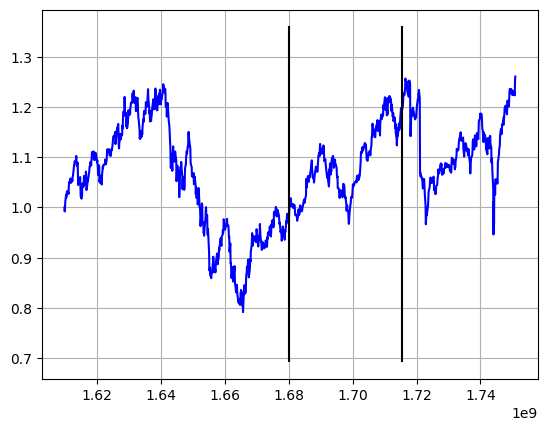

In [12]:
root_dir = "/Users/silas/work/machine_learning/LSTM/data/data_dump"
#root_dir = "/Users/silas/work/machine_learning/LSTM/data/my_repo"
stock_data = StockDataset(root_dir, seq_len=1124)

stock_nr = 3

print(stock_data.files)
#plt.plot(stock_data.data[stock_nr,-1,:], stock_data.data[stock_nr,0,:])

abs_data = stock_data.recons_absol()
x = abs_data[stock_nr,-1,:]
y = np.mean(abs_data[:,0,:], axis=0)

val_idx = int(0.5*len(x))
test_idx = int(0.75*len(x))

val_cut = x[val_idx]
test_cut = x[test_idx]

train_data = y[:val_idx]
val_data = y[val_idx:test_idx]
test_data = y[test_idx:]

for arr, text in zip([train_data, val_data, test_data], ["Train", "Validation", "Test"]):
    interval_return = arr[-1] / arr[0] -1
    print(f"{text}: {interval_return:.2%}")

plt.plot(x, y, color="blue")
plt.grid()
plt.vlines([val_cut, test_cut], np.min(y) - 0.1, np.max(y) + 0.1, color="black")
plt.show()

In [13]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, target_stock_idx, predict_day=1, max_deviation=False):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_len = seq_len
        self.max_deviation = max_deviation
        self.predict_day = predict_day

    def __len__(self):
        return self.data.shape[-1] -self.seq_len -self.predict_day +1

    def __getitem__(self, idx):
        x = self.data[:, :, idx : idx + self.seq_len]
        # Mask input data !!! Not Target !!!
        #if self.max_deviation != False:
        #    x = torch.where(torch.abs(x) > self.max_deviation, 0.0, x)
        y = self.data[:, target_stock_idx, idx + self.seq_len + self.predict_day -1]
        return x, y

In [14]:
def split_time_series(data, train_ratio=0.5, val_ratio=0.25):
    time_steps = data.shape[-1]
    #print(f"Time steps: {time_steps}")
    train_end = int(time_steps * train_ratio)
    val_end = int(time_steps * (train_ratio + val_ratio))
    return data[:, :, 0:train_end], data[:, :, train_end:val_end], data[:, :, val_end:]

In [15]:
def get_warmup_cosine_scheduler(optimizer, warmup_steps, total_steps, lr_max):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return current_step / warmup_steps
        else:
            progress = (current_step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1 + math.cos(math.pi * progress))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

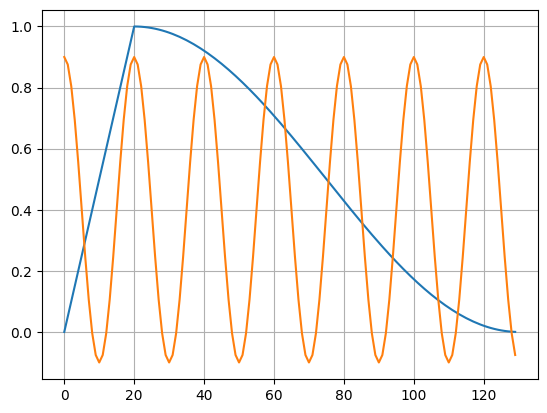

In [16]:
def cyclic_momentum(step):
    return 0.4 + 0.5 * np.cos(2 * np.pi * step / 20)

dummy_warmup_steps = 20
dummy_total_steps = 130
dummy_lr = np.zeros(dummy_total_steps)
dummy_momentum = np.zeros(dummy_total_steps)
dummy_steps = np.arange(0, dummy_total_steps, 1)

for step in dummy_steps:
    
    if step < dummy_warmup_steps:
        dummy_lr[step] = step / dummy_warmup_steps
    else:
        progress = (step - dummy_warmup_steps) / (dummy_total_steps - dummy_warmup_steps)
        dummy_lr[step] = 0.5 * (1 + math.cos(math.pi * progress))

    dummy_momentum[step] = cyclic_momentum(step)

plt.plot(dummy_steps, dummy_lr)
plt.plot(dummy_steps, dummy_momentum)
plt.grid()
plt.show()

In [17]:
# lstm model parameters
h_size = 16
n_layers = 3
num_studentT = 2

pre_heads = 2
time_heads = 2
asset_heads = 2

dropout = 0.5
seq_len = 16
batch_size = 1
deviation = (100.00, 0.0) # target deviation in loss function

# Meta head parameters
volume_h_size = 24
metrics_h_size = 32

# training main model
warmup_steps = 20
total_steps = 130
momentum_cycle = 20
lr_max=5e-6
weight_decay = 0.0 #5e-7
momentum = 0.8

# Training online learning model
lr_single = 1e-5
weight_decay_single = 0.0 #1e-6
momentum_single = 0.95

# Evaluation params
allow_short=False

In [18]:
data = stock_data.data[:,:6,:] # Pass OHLC

target_stock_idx = 1 # [open, close, high, low, volume, datetime]

value_size = data.shape[1] -1 # OHLC
in_size = len(stock_data.files) # number of stocks

print(f"Stock dimension: {stock_data.data.shape}")
print(f"Value size: {value_size}")

Stock dimension: (22, 7, 1124)
Value size: 5


In [19]:
train_ratio = 0.5
val_ratio = 0.25
max_deviation = 0.1 # Mask extreme data

###############
#### Data #####
###############
train, val, test = split_time_series(data, train_ratio=train_ratio, val_ratio=val_ratio)
print(f"Shapes: train={train.shape} val={val.shape} test={test.shape}")

train_ds = TimeSeriesDataset(train, seq_len, target_stock_idx, 1, max_deviation)
val_ds = TimeSeriesDataset(val, seq_len, target_stock_idx, 1, max_deviation)
test_ds = TimeSeriesDataset(test, seq_len, target_stock_idx, 1, max_deviation)
#print(f"Shapes: train={train.shape} val={val.shape} test={test.shape}")

# (Batch, in_size, seq_len)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

Shapes: train=(22, 6, 562) val=(22, 6, 281) test=(22, 6, 281)


In [20]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
print(f"device: {device}")

device: cpu


In [21]:
model = SuperModel(in_size, h_size, volume_h_size, metrics_h_size, n_layers, batch_size, seq_len, pre_heads, 
                   time_heads, asset_heads, num_studentT, value_size, dropout).to(device)

#optimizer = torch.optim.SGD(model.parameters(), lr=lr_max, weight_decay=weight_decay, momentum=momentum)
optimizer = ArbitraryMomentumSGD(
    model.parameters(),
    lr=lr_max,
    momentum_schedule=lambda step: 0.9 + 0.0 * torch.cos(2 * torch.pi * torch.tensor(step) / torch.tensor(momentum_cycle))  # Cyclic μ in [-0.1, 0.9]
)

scheduler = get_warmup_cosine_scheduler(
    optimizer, warmup_steps=warmup_steps, total_steps=total_steps, lr_max=lr_max
)

In [22]:
def calc_correct_preds(test_data, mu, sigma, nu, dist_weights, threshold):

    sigma = np.where(nu > 2, np.sqrt(nu / (nu-2)) * sigma, 1e10)
    
    # signal to noise ratio
    s_n = np.abs(mu) / sigma

    significant_out = np.where(s_n > threshold, np.where(mu > 0, 1, -1), 0.)

    samples = np.sum((significant_out * test_data) != 0)
    correct_sign = np.sum((significant_out * test_data) > 0.)

    return samples, correct_sign

In [23]:
def calc_alloc_return(
    mu, sigma, nu, dist_weights, real_returns,
    cash_threshold=0.3,
    temp=1.0,
    apply_confidence_mask=True,
    min_prob=0.1,
    max_loss=0.05,
    invest_sigmoid_scale=10.0,
    allow_short=False,
    x_grid_points=2000
):
    B, A, K = mu.shape
    device = mu.device

    # Add synthetic 'cash' asset
    mu = torch.cat([mu, torch.zeros(B, 1, K, device=device)], dim=1)
    sigma = torch.cat([sigma, torch.ones(B, 1, K, device=device)], dim=1)
    nu = torch.cat([nu, torch.full((B, 1, K), 10.0, device=device)], dim=1)
    dist_weights = torch.cat([dist_weights, torch.full((B, 1, K), 1e-9, device=device)], dim=1)
    real_returns = torch.cat([real_returns, torch.zeros(B, 1, device=device)], dim=1)

    def mix_pdf(x_grid):
        x = x_grid[:, None, None, None]
        dist = StudentT(loc=mu[None], scale=sigma[None], df=nu[None])
        pdf = dist.log_prob(x).exp()
        return (dist_weights[None] * pdf).sum(dim=-1)

    def integrate(x, y):
        return torch.trapz(y, x, dim=0)

    x_grid = torch.linspace(-10., 10., x_grid_points, device=device)
    pdf = mix_pdf(x_grid)
    pos_prob = integrate(x_grid, pdf * (x_grid > 0).float()[:, None, None])
    exp_gain = integrate(x_grid, pdf * x_grid[:, None, None])

    x_loss = torch.linspace(-10., -float(max_loss), x_grid_points, device=device)
    pdf_loss = mix_pdf(x_loss)
    loss_prob = integrate(x_loss, pdf_loss)

    pos_prob[:, -1] = cash_threshold
    if apply_confidence_mask:
        pos_prob *= (pos_prob > min_prob).float()
        #pos_prob *= (loss_prob < 0.10).float()  # optionally reinstate this

    alloc_raw = F.softmax(pos_prob / temp, dim=-1)

    mu_mean = mu.mean(dim=2)
    max_sig = pos_prob[:, :-1].max(dim=1, keepdim=True)[0]
    invest_ratio = torch.sigmoid((max_sig - cash_threshold) * invest_sigmoid_scale)
    allocations = alloc_raw * invest_ratio

    returns = torch.where(mu_mean > 0, real_returns, -real_returns) if allow_short else real_returns * (mu_mean > 0).float()
    port_ret = (allocations * returns).sum(dim=1)

    return allocations, port_ret

In [24]:
def compute_bootstrap_metrics(returns: torch.Tensor, n_bootstrap: int = 1000, ci: float = 0.95):
    """
    Compute bootstrapped performance metrics (CI) using torch.
    
    Args:
        returns (torch.Tensor): 1D tensor of daily returns.
        n_bootstrap (int): Number of bootstrap samples.
        ci (float): Confidence interval (e.g. 0.95).
    
    Returns:
        dict: {metric: (mean, lower_ci, upper_ci)}
    """
    assert returns.dim() == 1, "Returns must be 1D"
    returns = returns.detach()
    device = returns.device
    N = returns.shape[0]
    alpha = 1 - ci

    metrics = {
        'daily_return': [],
        'cumulative_return': [],
        'annualized_return': [],
        'sharpe_ratio': [],
        'max_drawdown': []
    }

    for _ in range(n_bootstrap):
        # Resample with replacement
        idx = torch.randint(0, N, (N,), device=device)
        sample = returns[idx]

        mean_r = sample.mean()
        std_r = sample.std(unbiased=False)
        sharpe = mean_r / (std_r + 1e-8) * torch.sqrt(torch.tensor(252.0, device=device))

        equity = torch.cumprod(1 + sample, dim=0)
        cum_return = equity[-1] - 1
        annual_ret = equity[-1].pow(252.0 / N) - 1

        peak = torch.cummax(equity, dim=0)[0]
        drawdown = (equity - peak) / (peak + 1e-8)
        max_dd = drawdown.min()

        metrics['daily_return'].append(mean_r.item())
        metrics['cumulative_return'].append(cum_return.item())
        metrics['annualized_return'].append(annual_ret.item())
        metrics['sharpe_ratio'].append(sharpe.item())
        metrics['max_drawdown'].append(max_dd.item())

    def summarize(values: list[float]):
        values = torch.tensor(values)
        mean = values.mean().item()
        lower = values.kthvalue(int((alpha / 2) * n_bootstrap))[0].item()
        upper = values.kthvalue(int((1 - alpha / 2) * n_bootstrap))[0].item()
        return mean, lower, upper

    return {k: summarize(v) for k, v in metrics.items()}

In [25]:
def calc_performance_metrics(returns: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Differentiable performance metrics using PyTorch ops.
    Assumes returns are daily returns as a 1D tensor.
    """
    # Ensure shape [N]
    returns = returns.view(-1)

    # Cumulative equity curve
    equity_curve = torch.cumprod(1 + returns, dim=0)

    # Annualized return
    total_return = equity_curve[-1]
    annualized_return = total_return.pow(252 / returns.size(0)) - 1

    # Sharpe ratio (risk-free rate = 0)
    sharpe_ratio = returns.mean() / (returns.std(unbiased=False) + 1e-8) * torch.sqrt(torch.tensor(252.0, device=returns.device))

    # Max drawdown
    rolling_max, _ = torch.cummax(equity_curve, dim=0)
    drawdowns = (equity_curve - rolling_max) / (rolling_max + 1e-8)
    max_drawdown = drawdowns.min()

    return sharpe_ratio, max_drawdown, annualized_return, equity_curve

In [26]:
##################
#### Training ####
##################

# Set some parameters for the calc_alloc_return function
train_cash_threshold = 0.05
train_temp = 0.01
train_min_prob = 0.50
train_max_loss = 0.05
train_invest_sigmoid_scale = 5

returns_buffer = []
performance_metrics = torch.zeros(6)

for p in model.parameters():
    p.requires_grad = True
for p in model.financial_performance_head.parameters():
    p.requires_grad = False
            
# Train LSTM model
for train_step in range(total_steps):
        
    # Training
    model.train()
    train_loss = 0
    perf_head_loss = 0
    
    for batch_x, batch_y in train_loader:
            
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        B, A, *_ = batch_x.shape

        # Generate a random permutation of assets
        perm = torch.randperm(A, device=batch_x.device)
        
        # Apply same permutation to both tensors along dim=1
        batch_x = batch_x[:, perm, :, :]
        batch_y = batch_y[:, perm]

        # train stock predictor
        optimizer.zero_grad()
        mu, sigma, nu, dist_weights = model(batch_x, performance_metrics)
        loss = mixture_student_t_loss(mu, sigma, nu, dist_weights, batch_y, deviation)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        alloc, port_ret = calc_alloc_return(
            mu, sigma, nu, dist_weights, batch_y,
            cash_threshold=train_cash_threshold,
            temp=train_temp,
            apply_confidence_mask=True,
            min_prob=train_min_prob,
            max_loss=train_max_loss,
            invest_sigmoid_scale=train_invest_sigmoid_scale,
            allow_short=allow_short
        )
        
        returns_buffer.append(port_ret)  # accumulate tensors directly
        
        if (len(returns_buffer) % 5 == 4):

            returns_tensor = torch.cat(returns_buffer, dim=0)  # shape [N], retains grad
            
            sharpe_ratio, max_drawdown, annualized_return, equity_curve = calc_performance_metrics(returns_tensor)
            
            performance_metrics = torch.tensor([
                                        sharpe_ratio,
                                        max_drawdown,
                                        annualized_return,
                                        sharpe_ratio - performance_metrics[0],
                                        max_drawdown - performance_metrics[1],
                                        annualized_return - performance_metrics[2]
                                    ], requires_grad=True, device=device)
            
            # Freeze everything except performance metrics head
            for p in model.parameters():
                p.requires_grad = False
            for p in model.financial_performance_head.parameters():
                p.requires_grad = True
                
            optimizer.zero_grad()
            perf_metrics_loss = performance_metrics_loss(performance_metrics)
            perf_metrics_loss.backward()
            optimizer.step()

            perf_head_loss += perf_metrics_loss.item()
 
            for p in model.parameters():
                p.requires_grad = True
            for p in model.financial_performance_head.parameters():
                p.requires_grad = False

    scheduler.step()
    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0

    returns_buffer = []
    total_ret, sample_count = 0, 0

    perf_head_loss = 0
    
    for val_x, val_y in val_loader:
        val_x = val_x.to(device)
        val_y = val_y.to(device)

        mu, sigma, nu, dist_weights = model(val_x, performance_metrics)
        loss = mixture_student_t_loss(mu, sigma, nu, dist_weights, val_y, deviation)

        val_loss += loss.item()

        alloc, port_ret = calc_alloc_return(
            mu, sigma, nu, dist_weights, val_y,
            cash_threshold=train_cash_threshold,
            temp=train_temp,
            apply_confidence_mask=True,
            min_prob=train_min_prob,
            max_loss=train_max_loss,
            invest_sigmoid_scale=train_invest_sigmoid_scale,
            allow_short=allow_short
        )
        
        returns_buffer.append(port_ret)  # accumulate tensors directly
        total_ret += port_ret.sum().item()
        sample_count += port_ret.shape[0]

        if (len(returns_buffer) % 5 == 4):

            returns_tensor = torch.cat(returns_buffer, dim=0)  # shape [N], retains grad
            
            sharpe_ratio, max_drawdown, annualized_return, equity_curve = calc_performance_metrics(returns_tensor)
            
            performance_metrics = torch.tensor([
                                        sharpe_ratio,
                                        max_drawdown,
                                        annualized_return,
                                        sharpe_ratio - performance_metrics[0],
                                        max_drawdown - performance_metrics[1],
                                        annualized_return - performance_metrics[2]
                                    ], requires_grad=True, device=device)
            
            perf_head_loss += perf_metrics_loss.item()
            
    if (train_step % 5 == 4):
        
        avg_val_loss = val_loss / len(val_loader)

        avg_perf_head_loss = perf_head_loss / len(val_loader)

        group = optimizer.param_groups[0]
        step = group['step']
        momentum_schedule = group['momentum_schedule']
        current_momentum = momentum_schedule(step)
            
        print(f"<========== Training metrics ==========>")
        print(f"Step              : {train_step+1}/{total_steps}")
        print(f"LR in microns     : {scheduler.get_last_lr()[0]*10e6:.1f}")
        print(f"Current Momentum  : {current_momentum:.2f}")
        print(f"Train Loss        : {avg_train_loss:.4f}")
        print(f"Validation Loss   : {avg_val_loss:.4f}")
        print(f"Perf metrics Loss : {avg_perf_head_loss:.4f}")
        print(f"<========== Quick Validation set Performance ==========>")
        print(f"Final cumulative return: {equity_curve[-1] - 1:.2%}")
        print(f"Annualized return: {annualized_return:.2%}")
        print(f"Sharpe ratio: {sharpe_ratio:.2f}")
        print(f"Max drawdown: {max_drawdown:.2%}")
        print(f"mu: {mu.mean():.4f} [{mu.min():.4f}, {mu.max():.4f}]")
        print(f"sigma: {sigma.mean():.4f} [{sigma.min():.4f}, {sigma.max():.4f}]")
        print(f"nu: {nu.mean():.4f} [{nu.min():.4f}, {nu.max():.4f}]")
        print(f"Weights: {dist_weights.mean():.4f} [{dist_weights.min():.4f}, {dist_weights.max():.4f}]")
        #print(f"Weights: {dist_weights.item():.2f}")
        #print(f"Significant points: {samples}")
        print()

<========== Training metrics ==========>
Step              : 5/130
LR in microns     : 12.5
Current Momentum  : 0.90
Train Loss        : 1.4854
Validation Loss   : 1.4850
Perf metrics Loss : -0.0097
<========== Quick Validation set Performance ==========>
Final cumulative return: 36.79%
Annualized return: 34.86%
Sharpe ratio: 2.21
Max drawdown: -11.95%
mu: 0.2558 [0.1584, 0.3518]
sigma: 1.2013 [1.1076, 1.3024]
nu: 3.2933 [3.1982, 3.3870]
Weights: 0.5000 [0.4785, 0.5215]

<========== Training metrics ==========>
Step              : 10/130
LR in microns     : 25.0
Current Momentum  : 0.90
Train Loss        : 1.4784
Validation Loss   : 1.4750
Perf metrics Loss : -0.0090
<========== Quick Validation set Performance ==========>
Final cumulative return: 36.63%
Annualized return: 34.70%
Sharpe ratio: 2.22
Max drawdown: -11.91%
mu: 0.2508 [0.1544, 0.3475]
sigma: 1.1900 [1.0975, 1.2902]
nu: 3.2909 [3.1923, 3.3878]
Weights: 0.5000 [0.4784, 0.5216]

<========== Training metrics ==========>
Step  

In [27]:
torch.save({
    'model_state_dict': model.state_dict(),
    #'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, "pre_trained.pth")

In [88]:
model = SuperModel(in_size, h_size, volume_h_size, metrics_h_size, n_layers, batch_size, seq_len, pre_heads, 
                   time_heads, asset_heads, num_studentT, value_size, dropout).to(device)

optimizer = ArbitraryMomentumSGD(
    model.parameters(),
    lr=lr_max,
    momentum_schedule=lambda step: 0.9 + 0.0 * torch.tensor(step)  # Cyclic μ in [-0.1, 0.9]
)

lr_single = 1e-2
weight_decay_single = 0.0
momentum_single = 0.9

# Adapt optimizer parameters
optimizer.param_groups[0]['lr'] = lr_single
optimizer.param_groups[0]['weight_decay'] = weight_decay_single
optimizer.param_groups[0]['momentum'] = momentum_single

checkpoint = torch.load("pre_trained.pth")
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#epoch = checkpoint['epoch']
#loss = checkpoint['loss']

<All keys matched successfully>

In [89]:
##############################
#### single step learning ####
##############################

# Now first calculate performance and the train

returns_buffer = []
allocs_buffer = []
total_ret, sample_count = 0, 0

train_loss = 0
perf_head_loss = 0

# disable dropout layer
model.disable_dropout()

for p in model.parameters():
    p.requires_grad = True
for p in model.financial_performance_head.parameters():
    p.requires_grad = False
              
performance_metrics = torch.zeros(6)

for batch_x, batch_y in test_loader:

    ######################
    ### first evaluate ###
    ######################
    model.eval()

    mu, sigma, nu, dist_weights = model(batch_x, performance_metrics)
    alloc, port_ret = calc_alloc_return(mu, sigma, nu, dist_weights, batch_y, cash_threshold=train_cash_threshold,temp=train_temp,apply_confidence_mask=True,min_prob=train_min_prob,max_loss=train_max_loss,invest_sigmoid_scale=train_invest_sigmoid_scale,allow_short=allow_short)

    returns_buffer.append(port_ret)  # accumulate tensors directly
    allocs_buffer.append(alloc)
    total_ret += port_ret.sum().item()
    sample_count += port_ret.shape[0]
    
    ##################
    ### Then train ###
    ##################
    model.train()
    
    if (len(returns_buffer) > 5):

        returns_tensor = torch.cat(returns_buffer, dim=0)  # shape [N], retains grad

        sharpe_ratio, max_drawdown, annualized_return, equity_curve = calc_performance_metrics(returns_tensor)

        performance_metrics = torch.tensor([
                                    sharpe_ratio,
                                    max_drawdown,
                                    annualized_return,
                                    sharpe_ratio - performance_metrics[0],
                                    max_drawdown - performance_metrics[1],
                                    annualized_return - performance_metrics[2],
                                ], dtype=torch.float32, device=device, requires_grad=True)
        
        # Freeze everything except performance metrics head
        for p in model.parameters():
            p.requires_grad = False
        for p in model.financial_performance_head.parameters():
            p.requires_grad = True
            
        optimizer.zero_grad()
        perf_metrics_loss = performance_metrics_loss(performance_metrics)
        perf_metrics_loss.backward()
        optimizer.step()

        perf_head_loss += perf_metrics_loss.item()

        for p in model.parameters():
            p.requires_grad = True
        for p in model.financial_performance_head.parameters():
            p.requires_grad = False
    
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    # train stock predictor
    optimizer.zero_grad()
    mu, sigma, nu, dist_weights = model(batch_x, performance_metrics)
    loss = mixture_student_t_loss(mu, sigma, nu, dist_weights, batch_y, deviation)

    train_loss += loss.item()

    loss.backward()
    optimizer.step()
    
avg_train_loss = train_loss / len(val_loader)

avg_perf_head_loss = perf_head_loss / len(val_loader)

print(f"<========== Online Learaning Performance ==========>")
print(f"Loss                   : {avg_train_loss:.4f}")
print(f"Perf metrics Loss      : {avg_perf_head_loss:.4f}")
print(f"Final cumulative return: {equity_curve[-1] - 1:.2%}")
print(f"Annualized return      : {annualized_return:.2%}")
print(f"Sharpe ratio           : {sharpe_ratio:.2f}")
print(f"Max drawdown           : {max_drawdown:.2%}")
print(f"mu                     : {mu.mean():.4f} [{mu.min():.4f}, {mu.max():.4f}]")
print(f"sigma                  : {sigma.mean():.4f} [{sigma.min():.4f}, {sigma.max():.4f}]")
print(f"nu                     : {nu.mean():.4f} [{nu.min():.4f}, {nu.max():.4f}]")
print(f"Weights                : {dist_weights.mean():.4f} [{dist_weights.min():.4f}, {dist_weights.max():.4f}]")

<========== Online Learaning Performance ==========>
Loss                   : 0.7451
Perf metrics Loss      : -0.0455
Final cumulative return: 50.46%
Annualized return      : 47.47%
Sharpe ratio           : 1.30
Max drawdown           : -15.41%
mu                     : 0.2338 [-2.5362, 3.5961]
sigma                  : 0.0859 [0.0255, 0.3280]
nu                     : 3.2086 [2.4763, 3.8172]
Weights                : 0.5000 [0.3286, 0.6714]


In [90]:
"""
best_cash_threshold, best_temp, best_min_prob, best_max_loss, best_invest_sigmoid_scale = [0.05, 0.05, 0.01, 0.05, 5]

all_returns = []  # Store all daily returns in time order
all_allocs = [] # Store all allocations for plotting

total_ret, sample_count = 0, 0
for test_x, test_y in test_loader:
    test_x, test_y = test_x.to(device), test_y.to(device)
    mu, sigma, nu, dist_weights = model(test_x)

    # === Apply current threshold to get allocation and returns ===
    alloc, port_ret = calc_alloc_return(
        mu, sigma, nu, dist_weights, test_y,
        cash_threshold=best_cash_threshold,
        temp=best_temp,
        apply_confidence_mask=True,
        min_prob=best_min_prob,
        max_loss=best_max_loss,
        invest_sigmoid_scale=best_invest_sigmoid_scale,
        allow_short=allow_short
    )

    total_ret += port_ret.sum().item()
    sample_count += port_ret.shape[0]

    all_returns.extend(port_ret.detach().cpu().numpy().flatten())
    all_allocs.extend(alloc.detach().cpu().numpy())

avg_daily_ret = total_ret / sample_count

sharpe_ratio, max_drawdown, annualized_return, equity_curve = calc_performance_metrics(all_returns)
"""

print(f"\n<========== Final Test Performance ==========>")
print(f"Final cumulative return: {equity_curve[-1] - 1:.2%}")
print(f"Annualized return: {annualized_return:.2%}")
print(f"Sharpe ratio: {sharpe_ratio:.2f}")
print(f"Max drawdown: {max_drawdown:.2%}")

print(f"\n<========== S&P 500 Performance ==========>")
print(f"Final cumulative return: {0.285 * len(equity_curve) / 390:.2%}")
print(f"Annualized return: 18.9%")
print(f"Sharpe ratio: 1.40")
print(f"Max drawdown: -8%")

print()
print(f"Number of samples: {len(equity_curve)}")

print(f"\n<========== Bootstrap results ==========>")
results = compute_bootstrap_metrics(returns_tensor, n_bootstrap=1000, ci=0.95)
for name, (mean_val, low, high) in results.items():
    print(f"{name.replace('_', ' ').title()}: {mean_val*100:.2f}% "
          f"[{low*100:.2f}%, {high*100:.2f}%]")


<========== Final Test Performance ==========>
Final cumulative return: 50.46%
Annualized return: 47.47%
Sharpe ratio: 1.30
Max drawdown: -15.41%

<========== S&P 500 Performance ==========>
Final cumulative return: 19.37%
Annualized return: 18.9%
Sharpe ratio: 1.40
Max drawdown: -8%

Number of samples: 265

<========== Bootstrap results ==========>
Daily Return: 0.18% [-0.11%, 0.44%]
Cumulative Return: 59.80% [-30.03%, 198.16%]
Annualized Return: 55.72% [-28.79%, 182.60%]
Sharpe Ratio: 129.64% [-84.26%, 313.94%]
Max Drawdown: -24.23% [-44.43%, -11.82%]


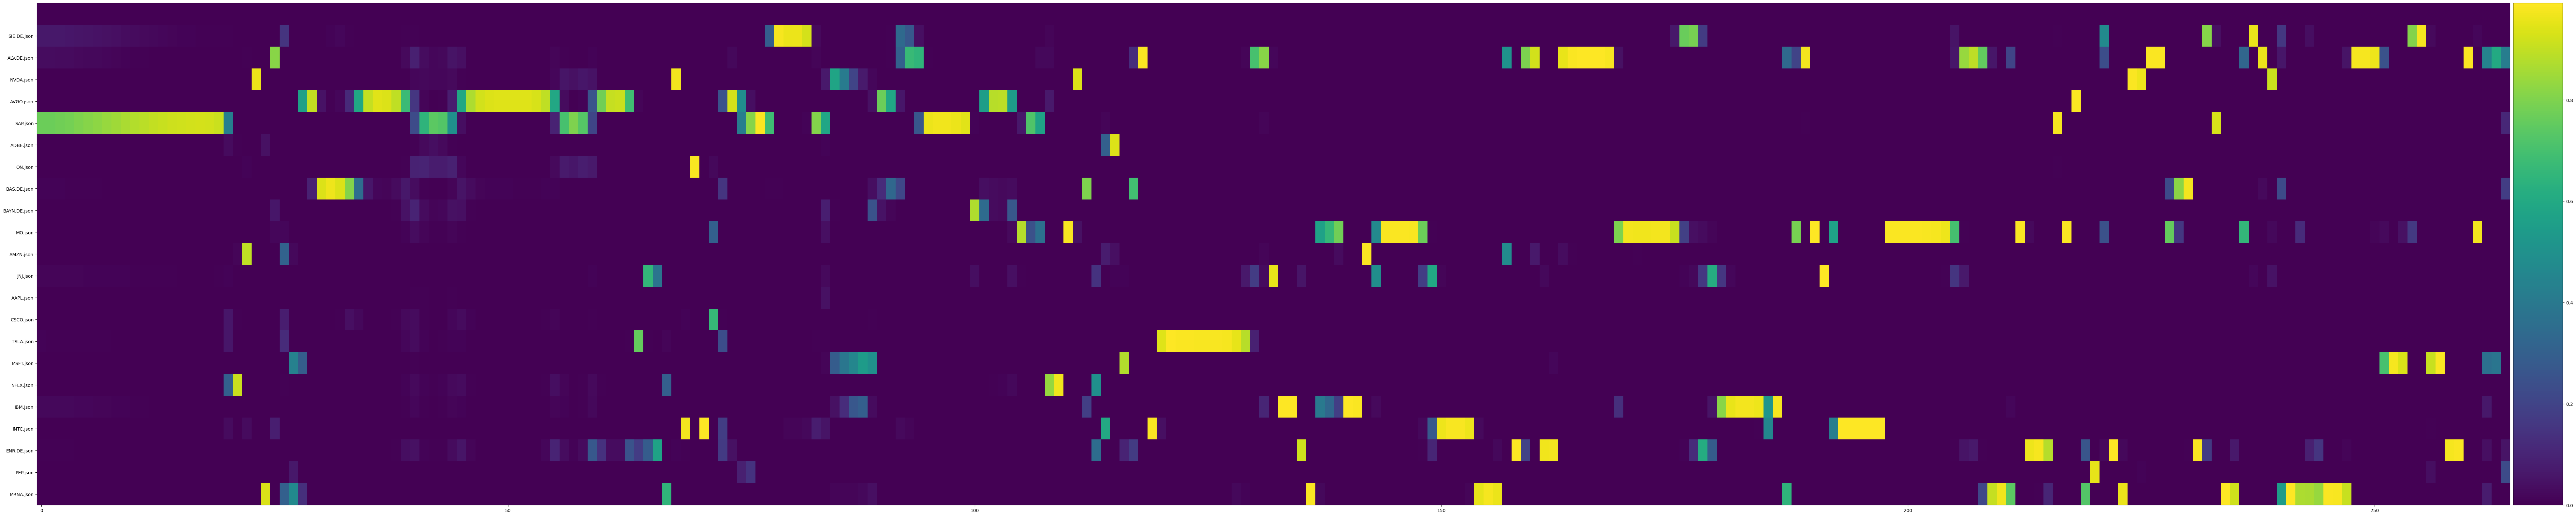

In [91]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming all_allocs and stock_data are already defined
allocs_tensor = torch.cat(allocs_buffer, dim=0)
allocs_tensor = allocs_tensor.detach().cpu().numpy()

fig, ax = plt.subplots(figsize=(100, 20))  # Large figure

# Use make_axes_locatable to attach a smaller colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)  # Smaller colorbar

# Plot heatmap
image = ax.imshow(allocs_tensor.T, origin="lower", vmin=0, aspect="auto")

# Add colorbar to the smaller axis
plt.colorbar(image, cax=cax)

# Set y-tick labels
ax.set_yticks(range(len(stock_data.files)))
ax.set_yticklabels(stock_data.files, rotation=0, ha="right", rotation_mode="anchor")

plt.show()